# Computing distance to default

In [80]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm
import warnings

from fredapi import Fred
from scipy.optimize import fsolve
from scipy.stats import norm

dir_path = './data/{}'
fred = Fred(api_key='b99003254085b30b6787af43a1aa3642')

## 0. Data

### 0.1. COMPUSTAT

In [2]:
original_compustat = pd.read_csv(dir_path.format('funda_2022.csv'), 
                                 usecols=['cusip', 'datadate', 'dlc', 'dltt', 'indfmt', 'datafmt', 'popsrc', 'fic', 'consol'],
                                 dtype={'cusip': str}).rename(
    columns={'datadate': 'date'})
original_compustat.info()
original_compustat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539318 entries, 0 to 539317
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     539318 non-null  object 
 1   indfmt   539318 non-null  object 
 2   consol   539318 non-null  object 
 3   popsrc   539318 non-null  object 
 4   datafmt  539318 non-null  object 
 5   cusip    539225 non-null  object 
 6   dlc      452467 non-null  float64
 7   dltt     461014 non-null  float64
 8   fic      539318 non-null  object 
dtypes: float64(2), object(7)
memory usage: 37.0+ MB


,date,indfmt,consol,popsrc,datafmt,cusip,dlc,dltt,fic
0,1961-12-31,INDL,C,D,STD,000032102,NaN,0.100,USA
1,1962-12-31,INDL,C,D,STD,000032102,NaN,0.000,USA
2,1963-12-31,INDL,C,D,STD,000032102,NaN,0.015,USA
3,1964-12-31,INDL,C,D,STD,000032102,0.088,0.522,USA
4,1965-12-31,INDL,C,D,STD,000032102,0.300,1.154,USA


In [3]:
compustat_df = original_compustat.copy() # [original_compustat['cusip'].isin(cusip_list)].copy()

compustat_df = compustat_df[(compustat_df['indfmt'] == 'INDL')]
compustat_df = compustat_df[(compustat_df['datafmt'] == 'STD')]
compustat_df = compustat_df[(compustat_df['popsrc'] == 'D')]
compustat_df = compustat_df[(compustat_df['fic'] == 'USA')]
compustat_df = compustat_df[(compustat_df['consol'] == 'C')]
compustat_df.drop(columns=['indfmt', 'datafmt', 'popsrc', 'fic', 'consol'], inplace=True)

# lagging 3 months
compustat_df['date'] = pd.to_datetime(compustat_df['date']).apply(lambda val: val + pd.DateOffset(days=90))
compustat_df['year'] = compustat_df['date'].apply(lambda val: val.year)
compustat_df = compustat_df[(compustat_df['year'] >= 1970) & (compustat_df['year'] <= 2020)]
compustat_df.drop(columns=['date'], inplace=True)

compustat_df['cusip'] = compustat_df['cusip'].str[0:6]

compustat_df['dlc'] = compustat_df['dlc'] * 1000000
compustat_df['dltt'] = compustat_df['dltt'] * 1000000
compustat_df['F'] = compustat_df['dlc'] + 0.5 * compustat_df['dltt']
compustat_df.drop(columns=['dlc', 'dltt'], inplace=True)
compustat_df.dropna(inplace=True)

def agg_F(series):
    return series.iloc[0]

compustat_df = compustat_df.groupby(['cusip', 'year']).agg({'F': agg_F})

compustat_df.dropna(inplace=True)
compustat_df.sort_values(by=['cusip', 'year'], inplace=True)
compustat_df.reset_index(inplace=True)

compustat_df.info()
compustat_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337501 entries, 0 to 337500
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cusip   337501 non-null  object 
 1   year    337501 non-null  int64  
 2   F       337501 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.7+ MB


,cusip,year,F
0,000032,1970,8027500.0
1,000032,1971,12836500.0
2,000032,1972,8016000.0
3,000032,1973,3500000.0
4,000032,1974,3500000.0


In [4]:
compustat_cusip_list = list(compustat_df['cusip'].unique())
print(len(compustat_cusip_list))

27807


### 0.2. DSF (CRSP)

In [5]:
def read_crsp(data_path):
    crsp_df = pd.read_csv(data_path,
                          usecols=['CUSIP', 'date', 'PRC', 'SHROUT', 'RET'],
                          dtype={'RET': str, 'CUSIP': str})
    crsp_df.rename(columns={'CUSIP': 'cusip'}, inplace=True)
    
    # lagging one month
    crsp_df['date'] = pd.to_datetime(crsp_df['date']).apply(lambda val: val + pd.DateOffset(days=30))
    crsp_df['year'] = crsp_df['date'].apply(lambda val: val.year)
    crsp_df = crsp_df[(crsp_df['year'] >= 1970) & (crsp_df['year'] <= 2020)]
    crsp_df.drop(columns=['date'], inplace=True)

    crsp_df['cusip'] = crsp_df['cusip'].str[0:6]
    
    crsp_df['RET'].replace(['B', 'C'], np.nan, inplace=True)
    crsp_df['RET'] = crsp_df['RET'].astype('float64')
    
    crsp_df['SHROUT'] = 1000 * crsp_df['SHROUT']
    crsp_df['E'] = np.abs(crsp_df['PRC']) * crsp_df['SHROUT']
    crsp_df.drop(columns=['PRC', 'SHROUT'], inplace=True)
    crsp_df.dropna(inplace=True)
    
    crsp_df.info()
    return crsp_df

In [6]:
original_dsf = read_crsp(dir_path.format('dsf.csv'))
original_dsf.head()

<class 'pandas.core.frame.DataFrame'>
Index: 83474969 entries, 2 to 90009793
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cusip   object 
 1   RET     float64
 2   year    int64  
 3   E       float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ GB


,cusip,RET,year,E
2,683916,-0.024390,1986,9200000.0
3,683916,0.000000,1986,9200000.0
4,683916,0.000000,1986,9200000.0
5,683916,0.050000,1986,9660000.0
6,683916,0.047619,1986,10120000.0


In [119]:
dsf_cusip_list = list(original_dsf['cusip'].unique())
print(len(dsf_cusip_list))

29319


In [120]:
cusip_list = list(set(compustat_cusip_list) & set(dsf_cusip_list))
print(len(cusip_list))

20578


In [121]:
cusip_list = [cusip_list[i] for i in random.sample(range(len(cusip_list)), 200)]
print(cusip_list)

['582803', '624581', '26942G', '457741', '23962Q', '531851', '731017', '703495', '983044', '681917', '46622G', '554790', '261226', '97111W', '682311', '465713', '18453H', '742562', '835756', '971378', '917311', '22674V', '148449', '573183', '372284', '83586Q', '898202', '70959W', '902667', '628188', '293799', '040460', '236280', '876750', '439336', '727557', '692830', '68217C', '233347', '640654', '36872P', '489084', '81218Q', '283362', '00431W', '59511X', '000032', '56845J', '278763', '913793', '594853', '437306', '542614', '597740', '737031', '125421', '036730', '335834', '502470', '36238K', '375046', '042198', '55933J', '36102A', '017361', '187268', '59000X', '74157H', '827054', '141337', '04010A', '351042', '156431', '52186N', '05564D', '744678', '14448C', '847612', '790654', '690310', '038181', '888314', '74934Q', '869716', '237891', '56781Q', '228411', '269246', '68216R', '52909K', '913016', '268162', '835848', '055485', '260174', '921212', '635906', '440694', '52110H', '85223W',

In [19]:
# cusip_list = ['706446']

In [122]:
def annualize_dsf(crsp_df):
    
    def agg_RET(series):
        return np.exp(np.sum(np.log(1 + series)))

    def agg_E(series):
        return series.iloc[0]

    def agg_sigma_E(group):
        return group['RET'].std() * np.sqrt(250)

    grouped_crsp = crsp_df.groupby(['cusip', 'year'])
    crsp_df = grouped_crsp.agg({'RET': agg_RET, 'E': agg_E})
    crsp_df['sigma_E'] = grouped_crsp.apply(agg_sigma_E)

    crsp_df.dropna(inplace=True)
    crsp_df.sort_values(by=['cusip', 'year'], inplace=True)
    crsp_df.reset_index(inplace=True)
    
    crsp_df.info()
    return crsp_df

In [123]:
dsf_df = annualize_dsf(original_dsf[original_dsf['cusip'].isin(cusip_list)].copy())
dsf_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cusip    2315 non-null   object 
 1   year     2315 non-null   int64  
 2   RET      2315 non-null   float64
 3   E        2315 non-null   float64
 4   sigma_E  2315 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 90.6+ KB


,cusip,year,RET,E,sigma_E
0,000032,1970,0.839080,26218125.0,0.787813
1,000032,1971,0.452052,23231250.0,0.651122
2,000032,1972,1.333330,10620000.0,0.635763
3,000032,1973,0.318183,13606875.0,0.716231
4,000032,1974,1.285711,3982500.0,0.892436


### 0.3. DAILYFED

<class 'pandas.core.series.Series'>
DatetimeIndex: 18230 entries, 1954-01-04 to 2023-11-17
Series name: None
Non-Null Count  Dtype  
--------------  -----  
17463 non-null  float64
dtypes: float64(1)
memory usage: 284.8 KB


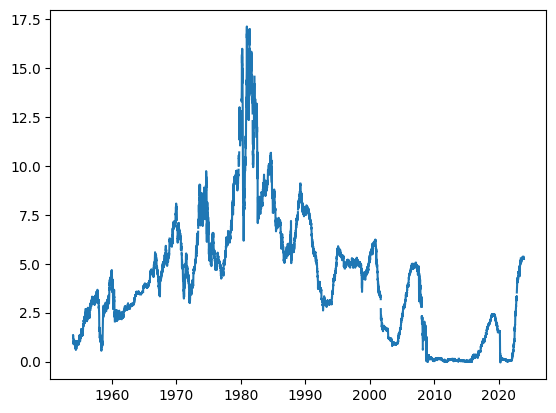

In [213]:
risk_free_df = fred.get_series('DTB3')
plt.plot(risk_free_df)
risk_free_df.info()

In [214]:
risk_free_df = risk_free_df.reset_index().rename(columns={'index': 'date', 0: 'rf'})
risk_free_df['year'] = risk_free_df['date'].apply(lambda val: val.year)
risk_free_df.drop(columns=['date'], inplace=True)
risk_free_df.dropna(inplace=True)

def agg_rf(series):
    return series.iloc[0]

risk_free_df = risk_free_df.groupby(['year']).agg({'rf': agg_rf})
risk_free_df.sort_values(by=['year'], inplace=True)
risk_free_df.reset_index(inplace=True)
risk_free_df.info()
risk_free_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    70 non-null     int64  
 1   rf      70 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


,year,rf
0,1954,1.33
1,1955,1.07
2,1956,2.50
3,1957,3.22
4,1958,2.78


### 0.4. Merging datasets

In [215]:
entire_df = pd.merge(compustat_df, dsf_df, on=['cusip', 'year'])
entire_df = pd.merge(entire_df, risk_free_df, on='year')
entire_df = entire_df[entire_df['F'] != 0]
entire_df.info()
entire_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1843 entries, 0 to 2140
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cusip    1843 non-null   object 
 1   year     1843 non-null   int64  
 2   F        1843 non-null   float64
 3   RET      1843 non-null   float64
 4   E        1843 non-null   float64
 5   sigma_E  1843 non-null   float64
 6   rf       1843 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 115.2+ KB


,cusip,year,F,RET,E,sigma_E,rf
0,000032,1970,8027500.0,0.839080,26218125.0,0.787813,7.92
1,017361,1970,307704000.0,1.116409,436632000.0,0.271423,7.92
2,257867,1970,2292000.0,0.667147,475533375.0,0.413566,7.92
3,268162,1970,3417500.0,0.803278,33215000.0,0.781258,7.92
4,283362,1970,697057000.0,1.045377,500652250.0,0.288580,7.92


## 1. Naive Computation

In [216]:
def distance_to_default(V, sigma_V, r, F, T):
    return (np.log(V / F) + (r - sigma_V * sigma_V / 2) * T) / (sigma_V * np.sqrt(T))

def naive_computation(row, sigma_V_option):
    V = row['E'] + row['F']
    sigma_D = (0.5 + 0.25 * row['sigma_E'] if sigma_V_option == 1 else 
               0.5 + 0.5 * row['sigma_E'] if sigma_V_option == 2 else
               0.25 * row['sigma_E']
              )
    sigma_V = (row['E'] * row['sigma_E'] + row['F'] * sigma_D) / V
    return distance_to_default(V, sigma_V, row['PREV_RET'], row['F'], 1)
    

def naive_computation_1(row):
    return naive_computation(row, 1)

def naive_computation_2(row):
    return naive_computation(row, 2)

def naive_computation_3(row):
    return naive_computation(row, 3)

entire_df['PREV_RET'] = entire_df.groupby('cusip')['RET'].shift(1)
entire_df.dropna(inplace=True)

entire_df['DD_m_1_1'] = entire_df.apply(naive_computation_1, axis=1)
entire_df['DD_m_1_2'] = entire_df.apply(naive_computation_2, axis=1)
entire_df['DD_m_1_3'] = entire_df.apply(naive_computation_3, axis=1)

entire_df['PD_m_1_1'] = entire_df['DD_m_1_1'].apply(lambda val: norm.cdf(-val))
entire_df['PD_m_1_2'] = entire_df['DD_m_1_2'].apply(lambda val: norm.cdf(-val))
entire_df['PD_m_1_3'] = entire_df['DD_m_1_3'].apply(lambda val: norm.cdf(-val))

entire_df.info()
entire_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 14 to 2140
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cusip     1655 non-null   object 
 1   year      1655 non-null   int64  
 2   F         1655 non-null   float64
 3   RET       1655 non-null   float64
 4   E         1655 non-null   float64
 5   sigma_E   1655 non-null   float64
 6   rf        1655 non-null   float64
 7   PREV_RET  1655 non-null   float64
 8   DD_m_1_1  1655 non-null   float64
 9   DD_m_1_2  1655 non-null   float64
 10  DD_m_1_3  1655 non-null   float64
 11  PD_m_1_1  1655 non-null   float64
 12  PD_m_1_2  1655 non-null   float64
 13  PD_m_1_3  1655 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 193.9+ KB


,cusip,year,F,RET,E,sigma_E,rf,PREV_RET,DD_m_1_1,DD_m_1_2,DD_m_1_3,PD_m_1_1,PD_m_1_2,PD_m_1_3
14,000032,1971,12836500.0,0.452052,23231250.0,0.651122,4.89,0.839080,2.529481,2.268431,3.683616,5.711561e-03,1.165146e-02,1.149742e-04
15,017361,1971,318919500.0,1.000023,452226000.0,0.235801,4.89,1.116409,5.227039,4.879832,12.210100,8.612326e-08,5.308822e-07,1.372755e-34
17,257867,1971,2267000.0,1.416218,318631500.0,0.326053,4.89,0.667147,16.977103,16.946761,17.165554,6.066491e-65,1.016768e-64,2.404361e-66
18,268162,1971,3791500.0,0.836727,25039000.0,0.585109,4.89,0.803278,4.477824,4.318228,5.105965,3.770388e-06,7.864349e-06,1.645554e-07
19,283362,1971,676590500.0,1.017677,469790125.0,0.227314,4.89,1.045377,3.517658,3.226241,12.349850,2.176867e-04,6.271388e-04,2.440103e-35


## 2. Directly Solving

In [217]:
def d1(V, sigma_V, r, F, T):
    return (np.log(V / F) + (r + sigma_V * sigma_V / 2) * T) / (sigma_V * np.sqrt(T))

def d2(V, sigma_V, r, F, T):
    return d1(V, sigma_V, r, F, T) - sigma_V * np.sqrt(T)

def equity(V, sigma_V, r, F, T):
    return V * norm.cdf(d1(V, sigma_V, r, F, T)) - F * np.exp(-r * T) * norm.cdf(d2(V, sigma_V, r, F, T))

def sigma_equity(V, sigma_V, r, F, T, E):
    return V * norm.cdf(d1(V, sigma_V, r, F, T)) * sigma_V / E
    
def direct_solving(row):
    
    def equations(p, r, F, T, E, sigma_E):
        V, sigma_V = p
        return equity(V, sigma_V, r, F, T) - E, sigma_equity(V, sigma_V, r, F, T, E) - sigma_E
    
    initial_guess = (row['E'] + row['F'], 0.5 * row['sigma_E'])
    V, sigma_V = fsolve(equations, initial_guess, args=(row['PREV_RET'], row['F'], 1, row['E'], row['sigma_E']))

    return distance_to_default(V, sigma_V, row['PREV_RET'], row['F'], 1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    entire_df['DD_m_2'] = entire_df.apply(direct_solving, axis=1)
entire_df['PD_m_2'] = entire_df['DD_m_2'].apply(lambda val: norm.cdf(-val))

entire_df.info()
entire_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 14 to 2140
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cusip     1655 non-null   object 
 1   year      1655 non-null   int64  
 2   F         1655 non-null   float64
 3   RET       1655 non-null   float64
 4   E         1655 non-null   float64
 5   sigma_E   1655 non-null   float64
 6   rf        1655 non-null   float64
 7   PREV_RET  1655 non-null   float64
 8   DD_m_1_1  1655 non-null   float64
 9   DD_m_1_2  1655 non-null   float64
 10  DD_m_1_3  1655 non-null   float64
 11  PD_m_1_1  1655 non-null   float64
 12  PD_m_1_2  1655 non-null   float64
 13  PD_m_1_3  1655 non-null   float64
 14  DD_m_2    1655 non-null   float64
 15  PD_m_2    1655 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 219.8+ KB


,cusip,year,F,RET,E,sigma_E,rf,PREV_RET,DD_m_1_1,DD_m_1_2,DD_m_1_3,PD_m_1_1,PD_m_1_2,PD_m_1_3,DD_m_2,PD_m_2
14,000032,1971,12836500.0,0.452052,23231250.0,0.651122,4.89,0.839080,2.529481,2.268431,3.683616,5.711561e-03,1.165146e-02,1.149742e-04,2.868017,2.065267e-03
15,017361,1971,318919500.0,1.000023,452226000.0,0.235801,4.89,1.116409,5.227039,4.879832,12.210100,8.612326e-08,5.308822e-07,1.372755e-34,8.910472,2.540792e-19
17,257867,1971,2267000.0,1.416218,318631500.0,0.326053,4.89,0.667147,16.977103,16.946761,17.165554,6.066491e-65,1.016768e-64,2.404361e-66,17.125902,4.756160e-66
18,268162,1971,3791500.0,0.836727,25039000.0,0.585109,4.89,0.803278,4.477824,4.318228,5.105965,3.770388e-06,7.864349e-06,1.645554e-07,4.756726,9.837902e-07
19,283362,1971,676590500.0,1.017677,469790125.0,0.227314,4.89,1.045377,3.517658,3.226241,12.349850,2.176867e-04,6.271388e-04,2.440103e-35,7.422996,5.725018e-14


## 3. Iterative

In [218]:
def iterative(row):
    
    def equity_equation(V, sigma_V, r, F, T, E):
        return equity(V, sigma_V, r, F, T) - E

    def sigma_equity_equation(sigma_V, V, r, F, T, E, sigma_E):
        return sigma_equity(V, sigma_V, r, F, T, E) - sigma_E

    prev_sigma_V = 0.5 * row['sigma_E']
    V =  fsolve(equity_equation, row['E'] + row['F'], args=(prev_sigma_V, row['PREV_RET'], row['F'], 1, row['E']))[0]
    sigma_V = row['E'] * row['sigma_E'] / V
    while np.abs(sigma_V / prev_sigma_V - 1) > 0.00001:
        V =  fsolve(equity_equation, V, args=(sigma_V, row['PREV_RET'], row['F'], 1, row['E']))[0]
        prev_sigma_V = sigma_V
        sigma_V = row['E'] * row['sigma_E'] / V

    return distance_to_default(V, sigma_V, row['PREV_RET'], row['F'], 1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    entire_df['DD_m_3'] = entire_df.apply(iterative, axis=1)
entire_df['PD_m_3'] = entire_df['DD_m_3'].apply(lambda val: norm.cdf(-val))

entire_df.info()
entire_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 14 to 2140
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cusip     1655 non-null   object 
 1   year      1655 non-null   int64  
 2   F         1655 non-null   float64
 3   RET       1655 non-null   float64
 4   E         1655 non-null   float64
 5   sigma_E   1655 non-null   float64
 6   rf        1655 non-null   float64
 7   PREV_RET  1655 non-null   float64
 8   DD_m_1_1  1655 non-null   float64
 9   DD_m_1_2  1655 non-null   float64
 10  DD_m_1_3  1655 non-null   float64
 11  PD_m_1_1  1655 non-null   float64
 12  PD_m_1_2  1655 non-null   float64
 13  PD_m_1_3  1655 non-null   float64
 14  DD_m_2    1655 non-null   float64
 15  PD_m_2    1655 non-null   float64
 16  DD_m_3    1655 non-null   float64
 17  PD_m_3    1655 non-null   float64
dtypes: float64(16), int64(1), object(1)
memory usage: 245.7+ KB


,cusip,year,F,RET,E,sigma_E,rf,PREV_RET,DD_m_1_1,DD_m_1_2,DD_m_1_3,PD_m_1_1,PD_m_1_2,PD_m_1_3,DD_m_2,PD_m_2,DD_m_3,PD_m_3
14,000032,1971,12836500.0,0.452052,23231250.0,0.651122,4.89,0.839080,2.529481,2.268431,3.683616,5.711561e-03,1.165146e-02,1.149742e-04,2.868017,2.065267e-03,2.869188,2.057635e-03
15,017361,1971,318919500.0,1.000023,452226000.0,0.235801,4.89,1.116409,5.227039,4.879832,12.210100,8.612326e-08,5.308822e-07,1.372755e-34,8.910472,2.540792e-19,8.639781,2.816049e-18
17,257867,1971,2267000.0,1.416218,318631500.0,0.326053,4.89,0.667147,16.977103,16.946761,17.165554,6.066491e-65,1.016768e-64,2.404361e-66,17.125902,4.756160e-66,17.125799,4.764572e-66
18,268162,1971,3791500.0,0.836727,25039000.0,0.585109,4.89,0.803278,4.477824,4.318228,5.105965,3.770388e-06,7.864349e-06,1.645554e-07,4.756726,9.837902e-07,4.756726,9.837888e-07
19,283362,1971,676590500.0,1.017677,469790125.0,0.227314,4.89,1.045377,3.517658,3.226241,12.349850,2.176867e-04,6.271388e-04,2.440103e-35,7.422996,5.725018e-14,7.149269,4.362076e-13


## Analysis

In [307]:
entire_df.sort_values(by=['cusip', 'year'], inplace=True)
entire_df.reset_index(drop=True, inplace=True)
entire_df.info()
entire_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cusip     1655 non-null   object 
 1   year      1655 non-null   int64  
 2   F         1655 non-null   float64
 3   RET       1655 non-null   float64
 4   E         1655 non-null   float64
 5   sigma_E   1655 non-null   float64
 6   rf        1655 non-null   float64
 7   PREV_RET  1655 non-null   float64
 8   DD_m_1_1  1655 non-null   float64
 9   DD_m_1_2  1655 non-null   float64
 10  DD_m_1_3  1655 non-null   float64
 11  PD_m_1_1  1655 non-null   float64
 12  PD_m_1_2  1655 non-null   float64
 13  PD_m_1_3  1655 non-null   float64
 14  DD_m_2    1655 non-null   float64
 15  PD_m_2    1655 non-null   float64
 16  DD_m_3    1655 non-null   float64
 17  PD_m_3    1655 non-null   float64
dtypes: float64(16), int64(1), object(1)
memory usage: 232.9+ KB


,cusip,year,F,RET,E,sigma_E,rf,PREV_RET,DD_m_1_1,DD_m_1_2,DD_m_1_3,PD_m_1_1,PD_m_1_2,PD_m_1_3,DD_m_2,PD_m_2,DD_m_3,PD_m_3
0,000032,1971,12836500.0,0.452052,23231250.0,0.651122,4.89,0.839080,2.529481,2.268431,3.683616,0.005712,0.011651,0.000115,2.868017,0.002065,2.869188,0.002058
1,000032,1972,8016000.0,1.333330,10620000.0,0.635763,3.69,0.452052,1.683703,1.457416,2.793287,0.046120,0.072501,0.002609,2.397689,0.008249,2.404358,0.008100
2,000032,1973,3500000.0,0.318183,13606875.0,0.716231,5.22,1.333330,3.766405,3.545527,4.512791,0.000083,0.000196,0.000003,3.774533,0.000080,3.774552,0.000080
3,000032,1974,3500000.0,1.285711,3982500.0,0.892436,7.52,0.318183,0.918943,0.716002,1.570998,0.179063,0.236995,0.058092,1.379516,0.083868,1.434714,0.075684
4,000032,1975,4000000.0,1.888890,4988250.0,0.696403,6.90,1.285711,2.709059,2.360760,4.284164,0.003374,0.009119,0.000009,2.706882,0.003396,2.708603,0.003378


* For the first method, DD_m_2 < DD_m_1 < DD_m_3. This is a direct consequence of sigma_V_2 > sigma_V_1 > sigma_V_3.
* Distances for the second and third methods are very similar. It makes sense since the third method uses the same direct equation fot the asset value as the second method, but calculates its sigma iteratively instead of the other direct equation.
* Distances for the first method are unstable: their proximity to the direct solution (method 2) differs. Sometimes the first distance is closer, sometimes the second, sometimes the third.

In [308]:
dd_list = ['DD_m_1_1', 'DD_m_1_2', 'DD_m_1_3', 'DD_m_2', 'DD_m_3']
pd_list = ['PD_m_1_1', 'PD_m_1_2', 'PD_m_1_3', 'PD_m_2', 'PD_m_3']

In [309]:
entire_df[dd_list].describe()

,DD_m_1_1,DD_m_1_2,DD_m_1_3,DD_m_2,DD_m_3
count,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000
mean,6.075199,5.834847,8.790245,7.198859,6.941089
std,5.869435,5.903341,7.407181,6.695338,9.146807
min,-0.887758,-1.397896,-0.644227,-2.562133,-184.298404
25%,2.441855,2.217782,3.945711,2.835701,2.836743
50%,4.494828,4.251861,7.170426,5.618408,5.513211
75%,7.840671,7.623586,11.948028,9.613831,9.528500
max,81.825694,81.490713,95.523178,94.357575,94.347847


* Again, distance for method 3 is extremely similar to the one for method 2. Only the minimum value for the third method seems to be an outlier.
* And distances for the first method, again, are closer to the direct solution on different levels.

In [310]:
entire_df[pd_list].describe()

,PD_m_1_1,PD_m_1_2,PD_m_1_3,PD_m_2,PD_m_3
count,1.655000e+03,1.655000e+03,1.655000e+03,1.655000e+03,1.655000e+03
mean,3.942131e-02,5.178594e-02,1.946818e-02,4.020908e-02,3.310995e-02
std,1.111424e-01,1.350305e-01,7.701005e-02,1.322166e-01,1.103026e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.242516e-15,1.243148e-14,3.327686e-33,3.495909e-22,7.987910e-22
50%,3.481317e-06,1.060006e-05,3.738233e-13,9.636235e-09,1.761727e-08
75%,7.306728e-03,1.328542e-02,3.978184e-05,2.286306e-03,2.278871e-03
max,8.126644e-01,9.189279e-01,7.402860e-01,9.947984e-01,1.000000e+00


<Axes: >

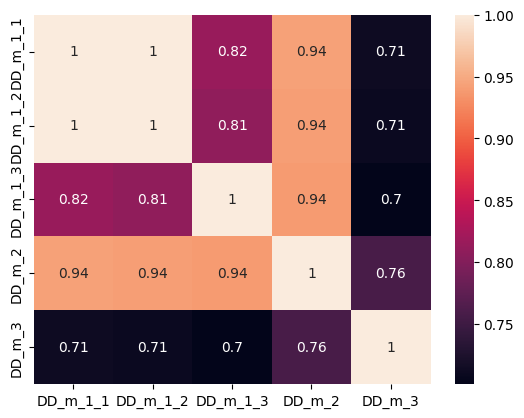

In [311]:
sns.heatmap(entire_df[dd_list].corr(), annot=True)

<Axes: >

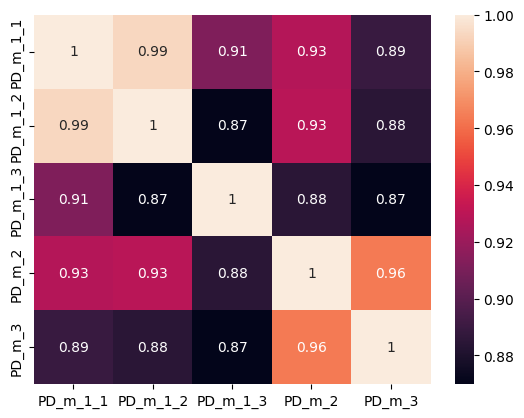

In [312]:
sns.heatmap(entire_df[pd_list].corr(), annot=True)

* Obviously, the distances for different methods highly correlate. They measure the same indicator -- otherwise, a there would likely be an implementation mistake

In [313]:
dd_by_year = {}
for dd_m in dd_list:
    dd_by_year[dd_m] = entire_df.groupby('year')[dd_m].agg(['mean',
                                                            lambda x: np.percentile(x, 25),
                                                            lambda x: np.percentile(x, 50),
                                                            lambda x: np.percentile(x, 75)]).rename(
        columns={'<lambda_0>': '25%', '<lambda_1>': '50%', '<lambda_2>': '75%'})

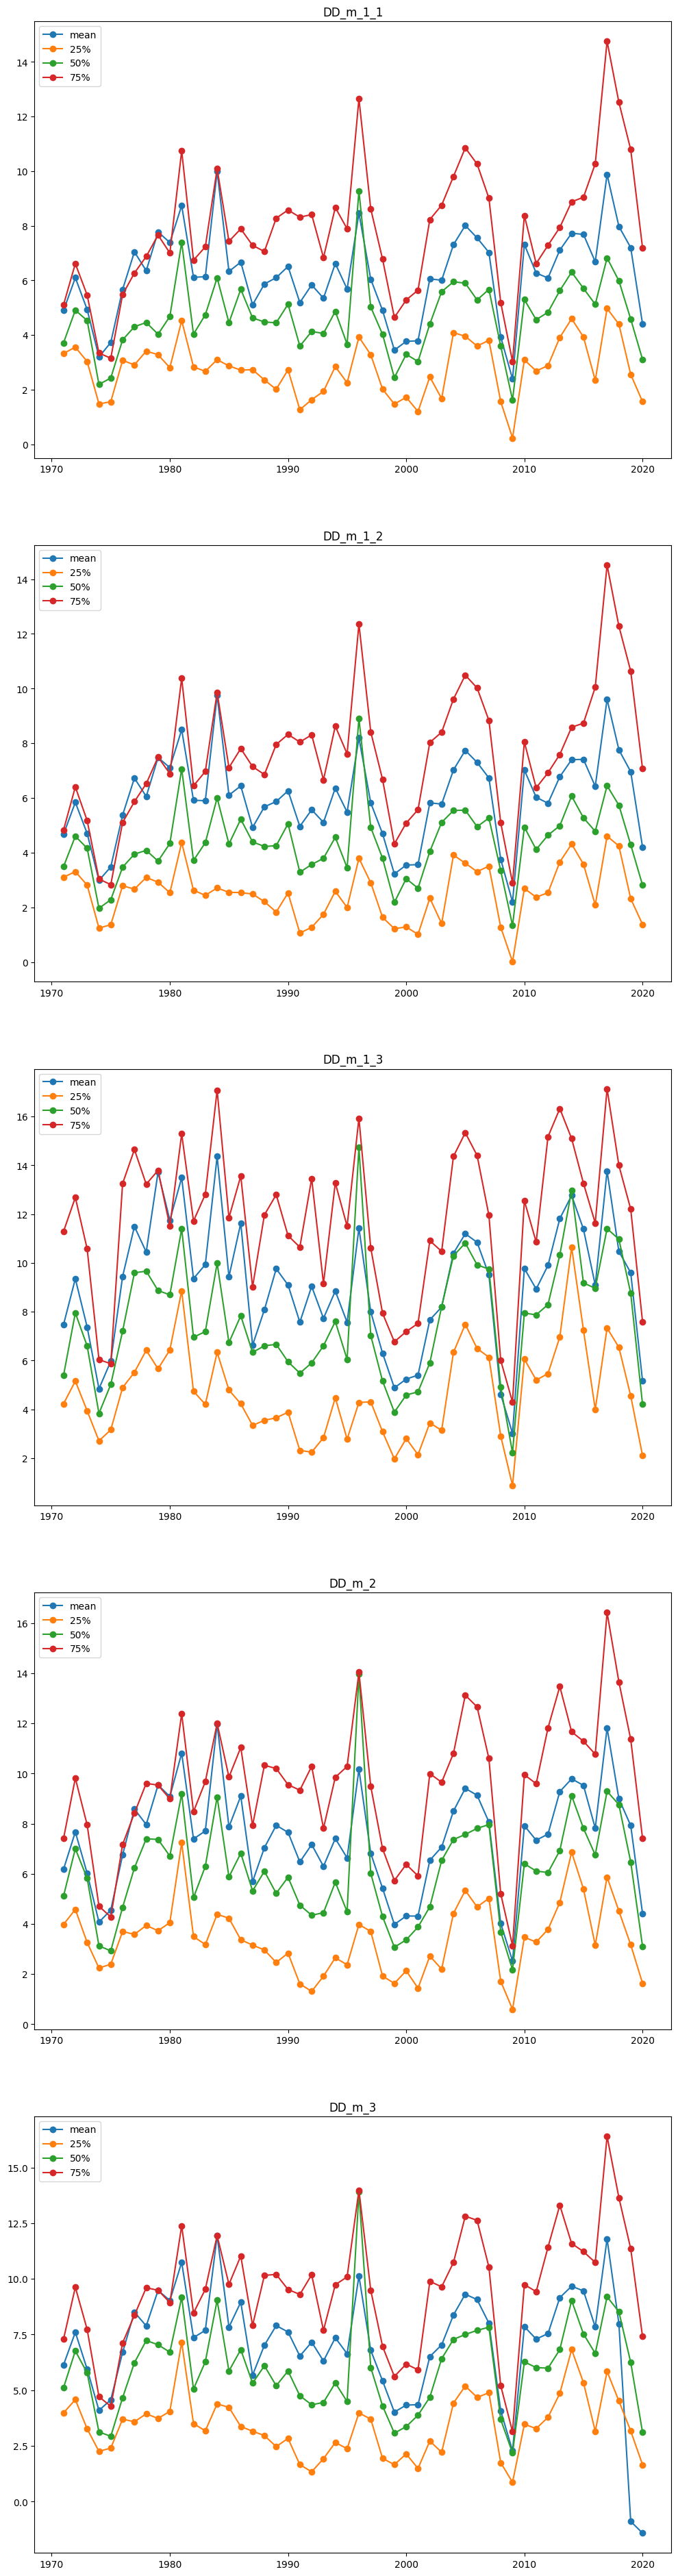

In [314]:
fig, axs = plt.subplots(len(dd_by_year), 1, figsize=(12, 48))
for i in range(len(dd_by_year)):
    dd_m, df = list(dd_by_year.items())[i]
    for column in df:
        axs[i].plot(df[column], '-o', label=column)
    axs[i].legend()
    axs[i].set_title(dd_list[i])


* Overall, distance to default is observed to be rather volatile. The only period with minor fluctuations is between 1985 and 1995.
* There are distinct drops in 1975, 1991, 1999-2001 (depending on the percentile), 2009 and 2020. It is very likely to be related to crisis.

### Recession data

<class 'pandas.core.series.Series'>
DatetimeIndex: 646 entries, 1970-01-01 to 2023-10-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
646 non-null    float64
dtypes: float64(1)
memory usage: 10.1 KB


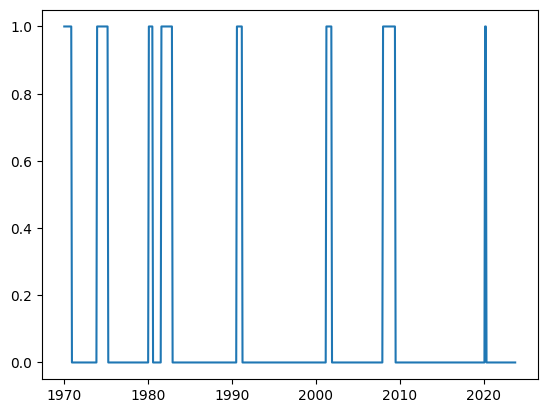

In [315]:
recession_df = fred.get_series('USREC')
recession_df = recession_df[recession_df.index >= '1970-01-01']
plt.plot(recession_df)
recession_df.info()

In [316]:
recession_df = recession_df.to_frame().reset_index().rename(columns={'index': 'year', 0: 'recession'})
recession_df['year'] = recession_df['year'].apply(lambda val: val.year)
recession_df = recession_df[recession_df['year'] >= 1970]
recession_df = recession_df.groupby('year')['recession'].agg([lambda x: 1 if x.sum() > 0 else 0]).rename(
    columns={'<lambda>': 'recession'})
recession_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 1970 to 2023
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   recession  54 non-null     int64
dtypes: int64(1)
memory usage: 864.0 bytes


In [317]:
recession_df.describe()

,recession
count,54.000000
mean,0.240741
std,0.431548
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [318]:
for dd_m, df in dd_by_year.items():
    dd_by_year[dd_m] = pd.merge(df, recession_df, left_index=True, right_index=True)

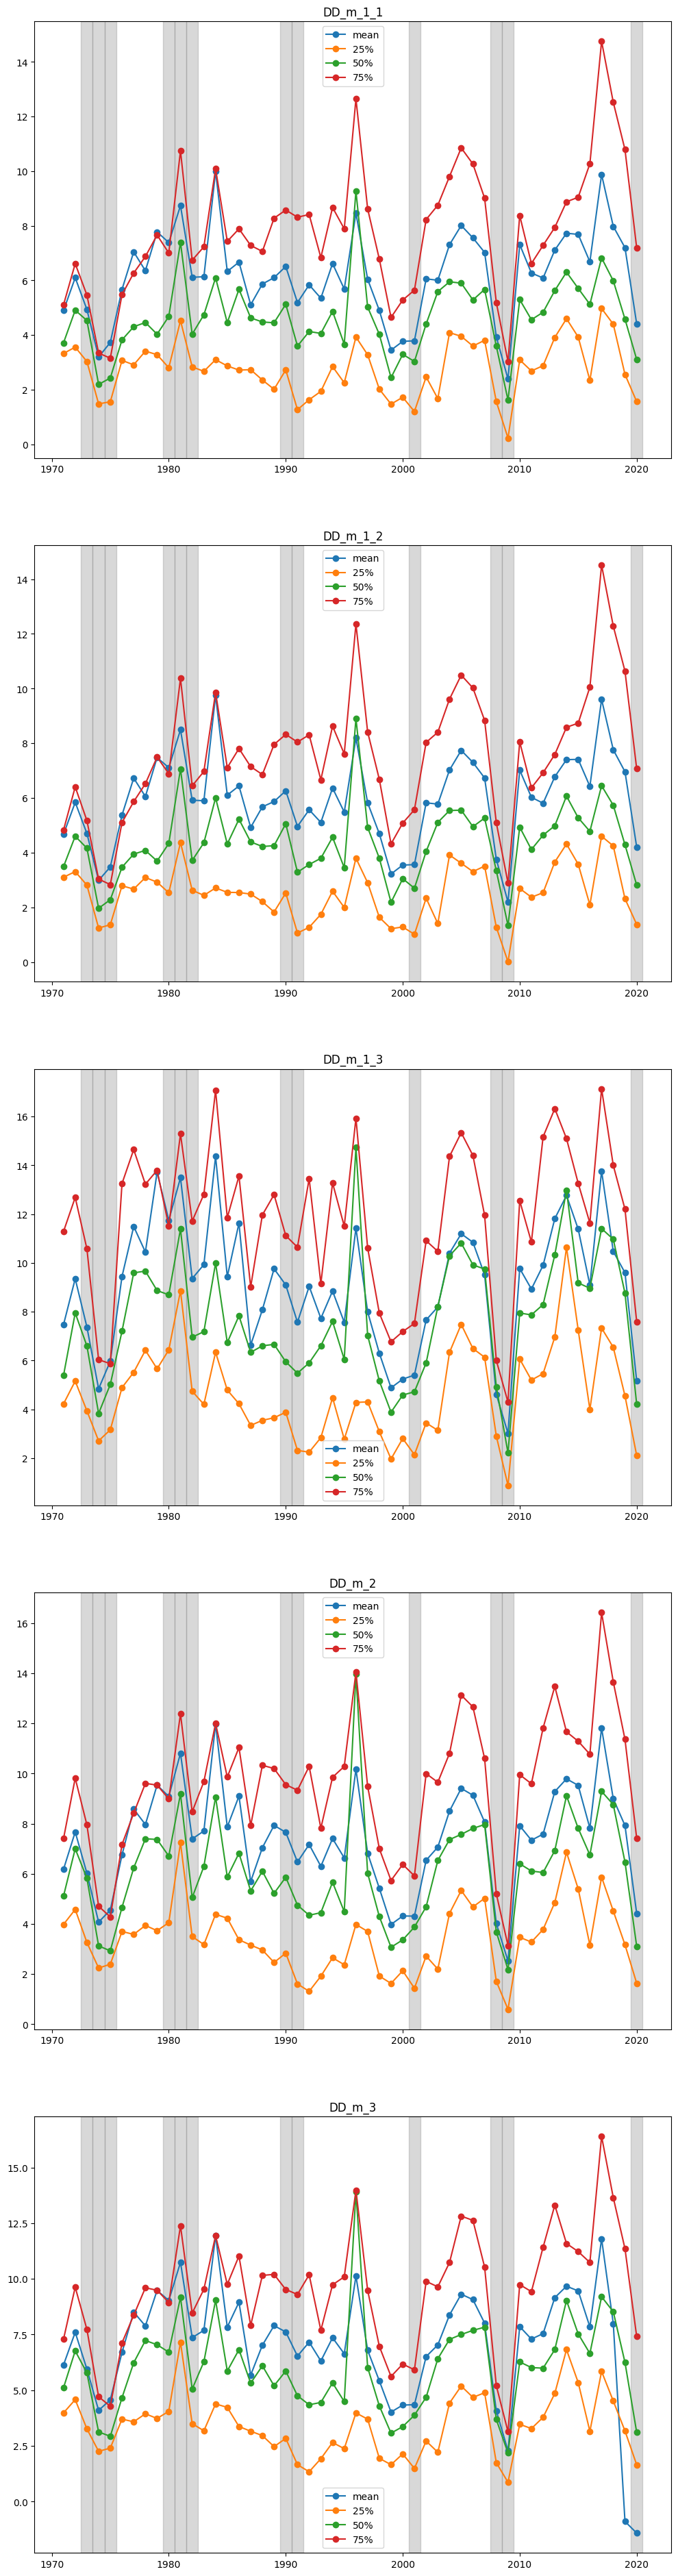

In [319]:
fig, axs = plt.subplots(len(dd_by_year), 1, figsize=(12, 48))
for i in range(len(dd_by_year)):
    dd_m, df = list(dd_by_year.items())[i]
    for column in df.drop(columns={'recession'}):
        axs[i].plot(df[column], '-o', label=column)
    for year, recession in zip(df.index, df['recession']):
        if recession:
            axs[i].axvspan(year - 0.5, year + 0.5, color='grey', alpha=0.3)
    axs[i].legend()
    axs[i].set_title(dd_list[i])


* Indeed, the falls seem to be related to the recession periods. The only case when the distance to default rocketed during the recession period was in 1980-1982.
* It is worth mentioning that the fall of distance to default is observed before the recession period with the minimum value during recession. It cannot be a mistake in lagging since the fall starts several years before the recession (the lag cannot be several years). Apparently, the distance to default is sensible to the state of economics and can "predict" the recession.

### Moody’s BAA-Fed Fund Spread

<class 'pandas.core.series.Series'>
DatetimeIndex: 646 entries, 1970-01-01 to 2023-10-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
646 non-null    float64
dtypes: float64(1)
memory usage: 10.1 KB


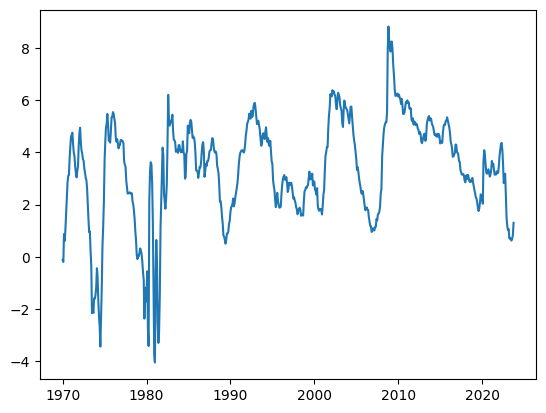

In [320]:
baa_spread_df = fred.get_series('BAAFFM')
baa_spread_df = baa_spread_df[baa_spread_df.index >= '1970-01-01']
plt.plot(baa_spread_df)
baa_spread_df.info()

In [321]:
baa_spread_df = baa_spread_df.to_frame().reset_index().rename(columns={'index': 'year', 0: 'baa_spread'})
baa_spread_df['year'] = baa_spread_df['year'].apply(lambda val: val.year)
baa_spread_df = baa_spread_df.groupby('year')['baa_spread'].agg(['mean']).rename(
    columns={'mean': 'baa_spread'})
baa_spread_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 1970 to 2023
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   baa_spread  54 non-null     float64
dtypes: float64(1)
memory usage: 864.0 bytes


In [322]:
baa_spread_df.describe()

,baa_spread
count,54.000000
mean,3.336645
std,1.831566
min,-1.005833
25%,2.227083
50%,3.512083
75%,4.749167
max,7.135833


In [323]:
for dd_m, df in dd_by_year.items():
    dd_by_year[dd_m] = pd.merge(df, baa_spread_df, left_index=True, right_index=True)

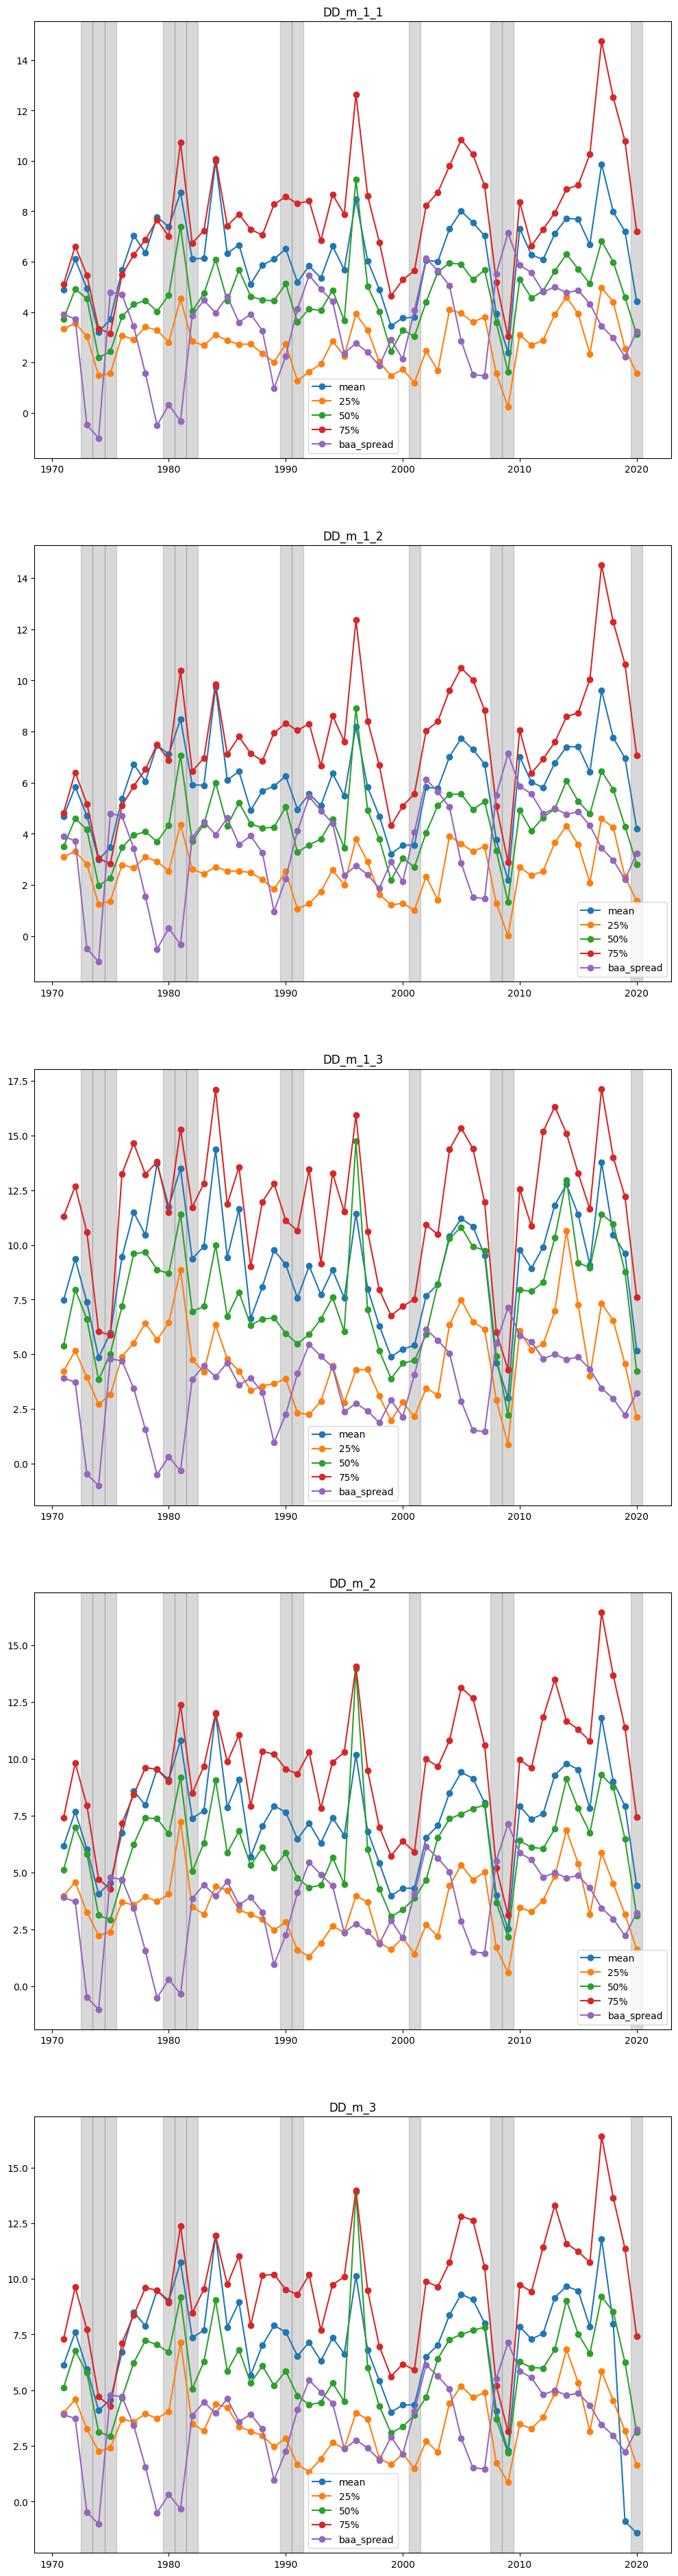

In [324]:
fig, axs = plt.subplots(len(dd_by_year), 1, figsize=(12, 48))
for i in range(len(dd_by_year)):
    dd_m, df = list(dd_by_year.items())[i]
    for column in df.drop(columns={'recession'}):
        axs[i].plot(df[column], '-o', label=column)
    for year, recession in zip(df.index, df['recession']):
        if recession:
            axs[i].axvspan(year - 0.5, year + 0.5, color='grey', alpha=0.3)
    axs[i].legend()
    axs[i].set_title(dd_list[i])


* The overall pattern of changes is very similar. But! The changes in distance to default seem to be lagged a couple of years in the future. It is possible that the changes in stocks's bonds are more sensible to their performance then distance to default and those changes indicate issues earlier than the distance.